# 005_image_classification_tricks
- when dealing with image classifications, here are some tricks to 📚study:
   
  - **Normalization**（♾️常规操作，统一的尺度范围 )
    标准化图像数据，稳定训练过程	训练阶段	使图像的像素值范围统一，避免训练不稳定

  - 可选技术：			
  - **Progressive Resizing-渐进式调整大小**

 
    在训练初期使用小图像，逐步增加图像分辨率（适合计算资源有限、图像尺寸很大）	*训练阶段* -- 提高训练速度和收敛性，适应不同分辨率的图像学习

  - **Test Time Augmentation (TTA)-测试时数据增强**
   
    在推理阶段对测试数据进行增强，提高模型稳定性	*测试阶段* -- 对同一张图像应用多种变换，融合多个预测结果得到更准确的输出


  - **Mixup-数据混合**

    通过将两张图像及标签混合增强样本多样性，避免过拟合（适合小数据集）	*训练阶段* -- 将两张图像及标签加权平均，生成新的训练样本，提高模型泛化能力
 
    - **Label Smoothing** 互补方法 `loss_func = LabelSmoothingCrossEntropy()`


- using a subset of ImageNet called **Imagenette** (selected 10 different categories from ImageNet for quick training)


- ⚠️A Hint😅: my device is MacOS M3MAX instead of GPU, however, the example exhibited in fastbook running here is quite slow (around 8 mins per epoch). I had to make some changes to validate these tricks! If you are also mac device user, just read the **MPS Headlines** below (running 45 seconds per epoch!).

- *for references:*

  - *content resource: **fastbook** #07_sizing_and_tta*
  - *ImageNet:: 1.3 million images of various sizes around 500 pixels across, in 1,000 categories, which took a few days to train*
  - *MNIST:: 50,000 28×28-pixel grayscale handwritten digits*
  - *CIFAR10:: 60,000 32×32-pixel color images in 10 classes*


In [1]:
from fastai.vision.all import *

In [2]:
path = untar_data(URLs.IMAGENETTE)

## Create a DLS and baseline model

In [20]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=Resize(460),
                  batch_tfms=RandomResizedCrop(260, min_scale=0.75))

In [21]:
dls = dblock.dataloaders(path, bs=24)

- ResNet（Residual Network）是一种深度神经网络架构，它使用残差连接（skip connections），帮助缓解训练中梯度消失的问题，并使得网络能够训练更深的层次。
- XResNet 是 ResNet 的一种扩展，它改进了网络结构，通常能够在多个计算机视觉任务上取得更好的结果。xresnet50 表示一个由 50 层组成的 XResNet 网络。50 指的是模型的层数。

In [22]:
model = xresnet50(n_out=dls.c) #n_out输出类别数, dls.c数据集的类别数, here is 10
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3) #very slow on macOS

epoch,train_loss,valid_loss,accuracy,time
0,1.648788,2.303311,0.285661,08:36
1,1.223694,1.552749,0.507842,08:27
2,0.980092,0.964101,0.712845,08:28
3,0.761844,0.700170,0.792009,08:29
4,0.591804,0.610395,0.822255,08:27


### MPS - Baseline model
From above training, my device is MacOS m3max (device: mps), the training time is really slow (8'30''per epoch)...Fastbook example used rtx3090 GPU only spent 0'30'' per epoch...

In order to test the following tricks, I decide to make some changes:
- item_tfms to smaller size (460 -> 128)
- batch_tfms to smaller size (260 -> 98) 
- model changes to resnet18 and use the `vision_learner` (includes Normalization already)

In [3]:
dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=Resize(128),
                  batch_tfms=RandomResizedCrop(98, min_scale=0.75))

dls = dblock.dataloaders(path, bs=32)

In [4]:
model = resnet18(num_classes=dls.c)
learn = vision_learner(dls, resnet18, metrics=accuracy)

SuggestedLRs(valley=0.001737800776027143)

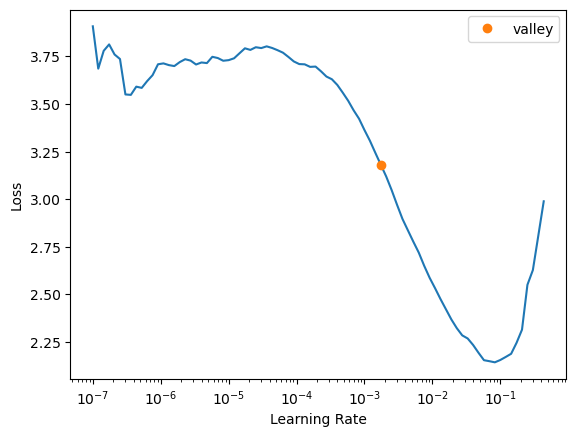

In [5]:
learn.lr_find()

In [6]:
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.495304,0.324447,0.907767,00:46
1,0.443975,0.289220,0.905527,00:46
2,0.354204,0.247439,0.921210,00:46
3,0.253806,0.233607,0.919343,00:47


After some changes, the computing speed is much faster than original learner! 0'46''per epoch now with higher accuracy (around 0.92)! Now here is my baseline 😌

## Normalization

- goal: transfer the data mean=0, std=1 to accelerate training and its stability. -> becomes especially important when using pretrained models
- Imagenette 是一个较小的数据集，它是从 ImageNet 中选出的，因此 ImageNet 的均值和标准差 可以用于对 Imagenette 数据集进行标准化。
- 使用预训练模型时，通常会使用 ImageNet 的统计数据（均值和标准差）来标准化图像，以确保输入数据的分布与预训练模型相符。
  如：`Normalize.from_stats(*imagenet_stats)`
- 通常在每次批次（batch）上进行，不会显著影响性能或耗时，尤其是在使用现代框架时。
- Normalization usually is automatically added in `vision_learner`; if not using vision_learner, should be included in `DataBlock()`.

In [23]:
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3]) #except the channel axis 1

(TensorImage([0.4427, 0.4235, 0.4038], device='mps:0'),
 TensorImage([0.2722, 0.2672, 0.2951], device='mps:0'))

In [36]:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock(), CategoryBlock),
                  get_items=get_image_files,
                  get_y=parent_label,
                  item_tfms=Resize(460),
                  batch_tfms=[RandomResizedCrop(size, min_scale=0.75),
                             Normalize.from_stats(*imagenet_stats)])
    return dblock.dataloaders(path, bs=bs)

`*imagenet_stats`相当于`imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])` --由整个imagenet数据得出。
- 如果遇到新数据集：

计算整个数据集的均值和标准差：
`mean, std = dls.train.x.mean(dim=[0,2,3]), dls.train.x.std(dim=[0,2,3])`

In [37]:
dls = get_dls(64, 224)
x,y = dls.one_batch()
x.mean(dim=[0,2,3]), x.std(dim=[0,2,3])

(TensorImage([-0.1099, -0.0711,  0.0485], device='mps:0'),
 TensorImage([1.2566, 1.2127, 1.3356], device='mps:0'))

In [ ]:
model = xresnet50(n_out=dls.c)
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.632865,2.250024,0.391337,01:02
1,1.294041,1.579932,0.517177,01:02
2,0.960535,1.069164,0.657207,01:04
3,0.730220,0.767433,0.771845,01:05
4,0.577889,0.550673,0.824496,01:06


## Progressive Resizing
what it is: start training using small images, and end training using large images. Spending most of the epochs training with small images, helps training complete much faster. Completing training using large images makes the final accuracy much higher.

In [44]:
dls = get_dls(64,128) # 第一次训练：较小的图像尺寸和较大的批次大小
learn = Learner(dls, xresnet34(n_out=dls.c), loss_func=CrossEntropyLossFlat(), metrics=accuracy) #resnet50 too slow in mps
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.586073,1.775445,0.415982,05:12
1,1.202580,1.480215,0.586632,05:44
2,0.902410,0.794755,0.744959,05:13
3,0.689305,0.650899,0.804705,05:25


In [45]:
learn.dls = get_dls(32, 224) # 第二次训练：较大的图像尺寸和较小的批次大小
learn.fine_tune(5, 1e-3) #更小的lr

epoch,train_loss,valid_loss,accuracy,time
0,0.798924,0.751305,0.773712,04:58


epoch,train_loss,valid_loss,accuracy,time
0,0.690535,0.712559,0.775952,05:07
1,0.683097,0.699285,0.788648,04:57
2,0.597943,0.609970,0.812173,04:47
3,0.499342,0.495658,0.847274,04:42
4,0.448878,0.467433,0.855489,04:43


### MPS: Add Progressive Resizing

In [8]:
#re-define get_dls() function:
def get_dls(bs, size):
    dblock = DataBlock(blocks=(ImageBlock(),CategoryBlock()),
                      get_items=get_image_files,
                      get_y=parent_label,
                      item_tfms=Resize(128),
                      batch_tfms=RandomResizedCrop(size, min_scale=0.75))
    return dblock.dataloaders(path, bs=bs)

In [9]:
#1st training with smaller size 
dls = get_dls(48, 48)
learner = vision_learner(dls, resnet18, metrics=accuracy)
learner.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.397299,0.291441,0.917102,00:45
1,0.356374,0.263499,0.914862,00:43
2,0.280798,0.240041,0.925691,00:44
3,0.213126,0.229397,0.926811,00:44


- baseline -> now : batch=32 -> 48, image size=98 -> 48
- accuracy **>0.925**, a little bit improve 🙂

In [12]:
#2nd fine_tune
learner.dls = get_dls(32,98)
learner.fine_tune(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.285308,0.138546,0.955937,00:46


epoch,train_loss,valid_loss,accuracy,time
0,0.257064,0.142240,0.955564,00:52
1,0.234063,0.131057,0.957057,00:52
2,0.116793,0.119836,0.959298,00:52


From the fine-tuned result, I feel that the Progressive Resizing trick is quite useful!

- training -> fine_tune : batch=48 -> 32, image size=48 -> 98
- accuracy **>0.955**, much more improvements!! 👍 (baseline acc is 0.92)

## Test Time Augmentation (TTA)
**During inference or validation**, creating *multiple versions* of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

- 计算开销：TTA 会显著增加推理的计算开销，因为它需要对每个图像进行多次推理。因此，在使用时需要权衡计算时间和准确度提升之间的关系。
- 适用场景：TTA 最常用于 分类任务，尤其是当你希望提高测试阶段的模型稳定性和准确性时。在实际应用中，TTA 在 Kaggle 比赛 和 验证集推理 中经常被用来提升模型效果。


In [ ]:
preds, targets = learn.tta()

In [47]:
accuracy(preds, targets).item() # >0.855489 tta稍高于last epoch training

0.855862557888031

### MPS: Add TTA

In [13]:
pred_mps, targ_mps = learner.tta()
accuracy(pred_mps, targ_mps).item()

0.968259871006012

😁 **accuracy=0.968**, even more improvement!! (baseline acc is 0.92; add Progressive resizing acc is 0.955)

## MixUp

- 通过`线性插值`方式将两张图像及其标签进行混合，从而生成新的样本。这种技术特别适用于`多类别分类任务`，有助于*防止过拟合*和*提高模型的泛化能力*。

  - MixUp 随机选取两张图像及其对应的标签 (x1, y1) 和 (x2, y2); λ 是从 Beta 分布 中采样得到的随机值（λ 的值在 [0, 1] 之间)

    `x = λ * x1 + (1 - λ) * x2 , y = λ * y1 + (1 - λ) * y2`
- as a **callback** `learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp())`

  
- MixUp 在模型已经学习了基本特征后才有效，所以需要更多的训练周期（eg. epochs>80 时use MixUp()有明显提升)
- 不仅限于vision，有人试过using `Mixup on activations` inside their models-> allows Mixup to be used for NLP and other data types too! 即`Activation MixUp` --通过对模型中间层的激活值(eg. a1,a2)进行混合，来增强模型的表示能力。
  - 计算softmax或sigmoid never equals to 1s or 0s, but Activation MixUp will push models closer more to 1s or 0s with more epochs training


In [48]:
learn = Learner(dls, xresnet34(n_out=dls.c), loss_func=CrossEntropyLossFlat(), metrics=accuracy, cbs=MixUp())
learn.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.870821,1.526629,0.493279,05:30
1,1.591731,1.533515,0.525392,06:05
2,1.385304,1.014480,0.684839,05:36
3,1.228271,0.785033,0.772218,05:32


accuracy低于baseline, epochs太少, mixup果然没有效果。

### Label smoothing
- MixUp也可能导致标签不确定性，此时需要补充技巧：**Label smoothing** --会将标签的 1 变成略小于 1 的值，并将 0 变成略大于 0 的值
`y = [0, 0, 1, 0] -> y_{smooth} = [0.1, 0.1, 0.8, 0.1]`

- as loss function:  `learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)`

In [ ]:
learn = Learner(dls, xresnet34(n_out=dls.c), loss_func=LabelSmoothingCrossEntropy(), metrics=accuracy)
learn.fit_one_cycle(4, 3e-3)

### MPS: Add mixup() and Label_smoothing

In [19]:
#just add mixup()
from fastai.callback.mixup import *
dls = get_dls(48, 98)
learner = vision_learner(dls, resnet18, metrics=accuracy, cbs=MixUp(0.3))
learner.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.148357,0.251010,0.926811,00:45
1,0.943257,0.258138,0.929425,00:45
2,0.863209,0.258656,0.936520,00:44
3,0.814270,0.248662,0.942121,00:44


Add Mixup in callback (around 0.93) is just a little bit improve than without Mixup (0.92)🤔 I think the number of epochs is not enough.

In [20]:
LabelSmoothingCrossEntropy??

Init signature:
LabelSmoothingCrossEntropy(
    eps: 'float' = 0.1,
    weight: 'Tensor' = None,
    reduction: 'str' = 'mean',
)
Docstring:      Same as `nn.Module`, but no need for subclasses to call `super().__init__`
Source:        
class LabelSmoothingCrossEntropy(Module):
    y_int = True # y interpolation
    def __init__(self, 
        eps:float=0.1, # The weight for the interpolation formula
        weight:Tensor=None, # Manual rescaling weight given to each class passed to `F.nll_loss`
        reduction:str='mean' # PyTorch reduction to apply to the output
    ): 
        store_attr()

    def forward(self, output:Tensor, target:Tensor) -> Tensor:
        "Apply `F.log_softmax` on output then blend the loss/num_classes(`c`) with the `F.nll_loss`"
        c = output.size()[1]
        log_preds = F.log_softmax(output, dim=1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=1) #We divide by that size at the return line

In [21]:
#add mixup + labelsmoothing (eps 0.8 - interpolation weight)
learner.loss_func = LabelSmoothingCrossEntropy(eps=0.8)
learner.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.274459,2.204993,0.925691,00:44
1,2.237962,2.207193,0.918969,00:44
2,2.230731,2.199317,0.926811,00:44
3,2.226471,2.196797,0.929798,00:44


In [22]:
dls = get_dls(32, 98)
learner.loss_func = LabelSmoothingCrossEntropy(eps=0.1)
learner.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.201308,0.750140,0.917102,00:44
1,1.161672,0.743647,0.918223,00:43
2,1.140195,0.714435,0.930919,00:44
3,1.111564,0.704118,0.933159,00:44


**eps=0.1 is better**， but add mixup + labelsmoothing is not improving.

In [23]:
#just add labelsmoothing
learner = vision_learner(dls, resnet18, metrics=accuracy, 
                         loss_func=LabelSmoothingCrossEntropy(eps=0.1))
learner.fit_one_cycle(4, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.001590,0.840392,0.902913,00:45
1,0.893168,0.763254,0.911128,00:46
2,0.785958,0.722831,0.926811,00:47
3,0.740733,0.711386,0.932039,00:47


baseline 0.92 -> labelsmoothing 0.93 not much improve🤔

## Conclusion
From this simple dataset (imagenette), using MPS device (instead of GPU) for training:

- vision_learner is quite useful💡 for image tasks than without normalization.
- progressive resizing trick is quite effective in improvement ✅
- tta truely boost performance as told ✅
- mixup and label smoothing tricks improve not much -> might need more epochs to train🙌🏻
